In [22]:
import numpy as np 
import matplotlib.pyplot as plt 
import ipywidgets
import ipywidgets as widgets
from scipy.signal import savgol_filter
import os 
import pandas as pd

In [23]:
#Setting plots parameters
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size']= 15
plt.style.use("seaborn-colorblind")

# Introduction
This notebook allows to analyse stress relaxation data obtained from the Chiaro/Piuma/ nanoindenters from Optics 11 Life. It is divided into several sections that should be ran in order. The notebook runs ipywidgets to make it more user friendly for non-programmers.
This is a work in progress and the notebook is at a very early stage. Please feel free to report any bugs and improvements!


## 1) Functions
This is the "backend" and needs only to be ran, but not modified.

In [24]:
def get_files(dir_path,ext=".txt"):
    """Gets files from one directory and stores them into a list."""
    files_list = [] #list of file names
    files_dir = [] #list of file directories
    for root, dirs, files in os.walk(dir_path):
        for name in files:
        #get only txt files but exclude position.txt
            if ext==".txt":
                if name.endswith(ext) and not name.endswith('position.txt'):
                    files_list.append(name)
                    files_dir.append(os.path.join(root, name))
            else:
            #for other extensions, do not exclude files
                if name.endswith(ext):
                    files_list.append(name)
                    files_dir.append(os.path.join(root, name))
    return files_list, files_dir

def read_file(f): 
    """
    Reads one .txt file 
    """
    with open(f, encoding='utf-8', errors='ignore') as dynamic:
        stopLine = 'Time (s)'
        numeric = False
        data = []
        for riga in dynamic:
            if numeric is False:
                if riga[0:len(stopLine)] == stopLine:
                    numeric = True
            else:
                line = riga.strip().replace(',', '.').split('\t')
                # Time (s) Load (uN) Indentation (nm) Cantilever (nm) Piezo (nm) Auxiliary
                # skip  #5 auxiliary if present
                data.append([float(line[0]), float(line[1])*1000.0, float(line[2]),
                            float(line[3]), float(line[4])])
        data = np.array(data)
    return data
      

#TODO 
def find_contact_point(z,f,al_th=10.0,al_ls=2000.0,avg_area=100.0):
    """Find CP by "thresholding" data and returns CP index"""
    yth = al_th
    x = z
    y = f
    if yth > np.max(y) or yth < np.min(y):
        return False
    jrov = 0
    for j in range(len(y)-1, 1, -1):
        if y[j] > yth and y[j-1] < yth:
            jrov = j
            break
    x0 = x[jrov]
    dx = al_ls
    ddx = avg_area
    if ddx <= 0:
        jxalign = np.argmin((x - (x0 - dx)) ** 2)
        f0 = y[jxalign]
    else:
        jxalignLeft = np.argmin((x-(x0-dx-ddx))**2)
        jxalignRight = np.argmin((x-(x0-dx+ddx))**2)
        f0 = np.average(y[jxalignLeft:jxalignRight])
    jcp = jrov
    for j in range(jrov, 1, -1):
        if y[j] > f0 and y[j-1] < f0:
            jcp = j
            break
    return jcp

def getMedCurve(xar, yar,loose=True, threshold=3, error=False):
    """
    Takes repeated nummerical data (replicates stored in a multi dimensional list) 
    and computes the average and error. Useful for displaying "average" plots
    with error bands.
    This function was taken from the following github repo (https://github.com/CellMechLab/nanoindentation),
    author Dr Massimo Vassalli at the Cellular Mechanobiology Lab, University of Glasgow.
    """
    if loose is False:
        xmin = -np.inf
        xmax = np.inf
        deltax = 0
        nonecount = 0
        for x in xar:
            if x is not None and np.min(x) is not None:
                xmin = np.max([xmin, np.min(x)])
                xmax = np.min([xmax, np.max(x)])
                deltax += ((np.max(x)-np.min(x))/(len(x)-1))
            else:
                nonecount += 1
        deltax /= (len(xar)-nonecount)
        xnew = np.linspace(xmin, xmax, int((xmax-xmin)/(deltax)))
        ynew = np.zeros(len(xnew))
        for i in range(len(xar)):
            if xar[i] is not None and np.min(xar[i]) is not None:
                ycur = np.interp(xnew, xar[i], yar[i])
                ynew += ycur
        ynew /= (len(xar)-nonecount)
    else:
        xmin = np.inf
        xmax = -np.inf
        deltax = 0
        for x in xar:
            try:
                xmin = np.min([xmin, np.min(x)])
                xmax = np.max([xmax, np.max(x)])
                deltax += ((np.max(x) - np.min(x)) / (len(x) - 1))
            except TypeError:
                return
        deltax /= len(xar)
        xnewall = np.linspace(xmin, xmax, int((xmax - xmin) / deltax))
        ynewall = np.zeros(len(xnewall))
        count = np.zeros(len(xnewall))
        ys = np.zeros([len(xnewall), len(xar)])
        for i in range(len(xar)):
            imin = np.argmin((xnewall - np.min(xar[i])) ** 2)  # +1
            imax = np.argmin((xnewall - np.max(xar[i])) ** 2)  # -1
            ycur = np.interp(xnewall[imin:imax], xar[i], yar[i])
            ynewall[imin:imax] += ycur
            count[imin:imax] += 1
            for j in range(imin, imax):
                ys[j][i] = ycur[j-imin]
        cc = count >= threshold
        xnew = xnewall[cc]
        ynew = ynewall[cc] / count[cc]
        yerrs_new = ys[cc]
        yerr = []
        for j in range(len(yerrs_new)):
            squr_sum = 0
            num = 0
            std = 0
            for i in range(0, len(yerrs_new[j])):
                if yerrs_new[j][i] != 0:
                    squr_sum += (yerrs_new[j][i] - ynew[j]) ** 2
                    num += 1
            if num > 0:
                std = np.sqrt(squr_sum / num)
            yerr.append(std)
        yerr = np.asarray(yerr)
    if error == False:
        return xnew[:-1], ynew[:-1]
    elif error == True:
        return xnew[:-1], ynew[:-1], yerr[:-1]

# Input Data 
Below, input the directory where all files to be analysed are stored. This can be a folder with one curve, a single matrix scan, a folder withmultiple matrix scan folders inside... etc!

In [25]:
#Please enter directory in the quotes
dirw=widgets.Text(
    value='',
    placeholder='Please enter the files directory',
    description='Directory:',
    disabled=False
)
display(dirw)

Text(value='', description='Directory:', placeholder='Please enter the files directory')

In [27]:
#Get files from input directory
datanames,data = get_files(dirw.value,ext=".txt") 
#Check whether correct data has been loaded by printing first 5 files
data[0:5]

['/Users/giuseppeciccone/Library/CloudStorage/OneDrive-UniversityofGlasgow/PhD/PyModules/stressrelaxnano/test_data/LS1_2_Imode_medtip/matrix_scan07/LS1_2_Imode_medtip S-1 X-1 Y-2 I-1.txt',
 '/Users/giuseppeciccone/Library/CloudStorage/OneDrive-UniversityofGlasgow/PhD/PyModules/stressrelaxnano/test_data/LS1_2_Imode_medtip/matrix_scan07/LS1_2_Imode_medtip S-1 X-1 Y-3 I-1.txt',
 '/Users/giuseppeciccone/Library/CloudStorage/OneDrive-UniversityofGlasgow/PhD/PyModules/stressrelaxnano/test_data/LS1_2_Imode_medtip/matrix_scan07/LS1_2_Imode_medtip S-1 X-1 Y-1 I-1.txt',
 '/Users/giuseppeciccone/Library/CloudStorage/OneDrive-UniversityofGlasgow/PhD/PyModules/stressrelaxnano/test_data/LS1_2_Imode_medtip/matrix_scan08/LS1_2_Imode_medtip S-1 X-4 Y-3 I-1.txt',
 '/Users/giuseppeciccone/Library/CloudStorage/OneDrive-UniversityofGlasgow/PhD/PyModules/stressrelaxnano/test_data/LS1_2_Imode_medtip/matrix_scan08/LS1_2_Imode_medtip S-1 X-1 Y-2 I-1.txt']

# Screening 
The plot below serves to *select* the thresholds for screening and aligning curves in the next cell. The following thresholds can be adjusted: 

1. TMAX: the maximum time one wants to display and analyse the data for.
2. fmin: the minimum acceptable value for the maximum (peak) force.
3. fmax: the maximum acceptable value for the maximum (peak) force.

Every curve whose peak force falls outside the range given by (fmin,fmax) will be discarded automatically.
tip: adjust sliders by clicking on approximate desired value. Just sliding will update the plot for each value the slider passes through, resulting in a laggy visual update.

In [28]:
def first_plot(TMAX=20.0,fmin=0.0,fmax=50.0):
    fig,ax=plt.subplots(1,1)
    tall = []
    fall = []
    for _, file in enumerate(data):
        curve=read_file(file) 
        z=curve[:,4]
        f=curve[:,1]
        t=curve[:,0]
        i_max_time = np.argmin((t-TMAX)**2)
        t=t[:i_max_time]
        f=f[:i_max_time]
        #Offset curves 
        off = f[0] #first point
        #if forst point is negative, align
        if off <0: 
            f = f-off
        else:
            f = f
        #Final variables to append
        normf=f
        ax.plot(t,normf,alpha=1,lw=0.1,c='k')
        ax.axhline(fmin,c="salmon")
        ax.axhline(fmax,c="salmon")
        ax.axvline(TMAX)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('force (uN)')
    plt.show()

plot1w=widgets.interactive(first_plot, TMAX=(0.0,30.0,0.5),fmin=(0.0,10.0,0.1),fmax=(15.0,30.0,0.1))
display(plot1w)

interactive(children=(FloatSlider(value=20.0, description='TMAX', max=30.0, step=0.5), FloatSlider(value=0.0, …

# Adjusting

In addition, sometimes the maximum force does not correspond to the start of the relaxation due to noise in the data (eg drift). If some of your curves contain this feature, check the checkbox "Multimax?" and select a time threshold over which the maximum force is considered noise (Time mm (s)). All curves whose maximum force occurs after Time mm (s) are discarded.

Given the above specified thresholds, the code below finds the maximum force and corresponding time and aligns this value to 0. All curves should now start from t=0.

In the end, the average curve is plotted (red).

In [29]:
thresholdw=widgets.Checkbox(
    value=False,
    description='Threshold data',
    disabled=False
)

display(thresholdw)

multimaxw=widgets.Checkbox(
    value=False,
    description='Multimax?',
    disabled=False
)

display(multimaxw)

time_multimax = widgets.FloatSlider(
    value=5.0,
    min=0,
    max=50.0,
    step=0.1,
    description='Time MM (s)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(time_multimax)

Checkbox(value=False, description='Threshold data')

Checkbox(value=False, description='Multimax?')

FloatSlider(value=5.0, description='Time MM (s)', max=50.0, readout_format='.1f')

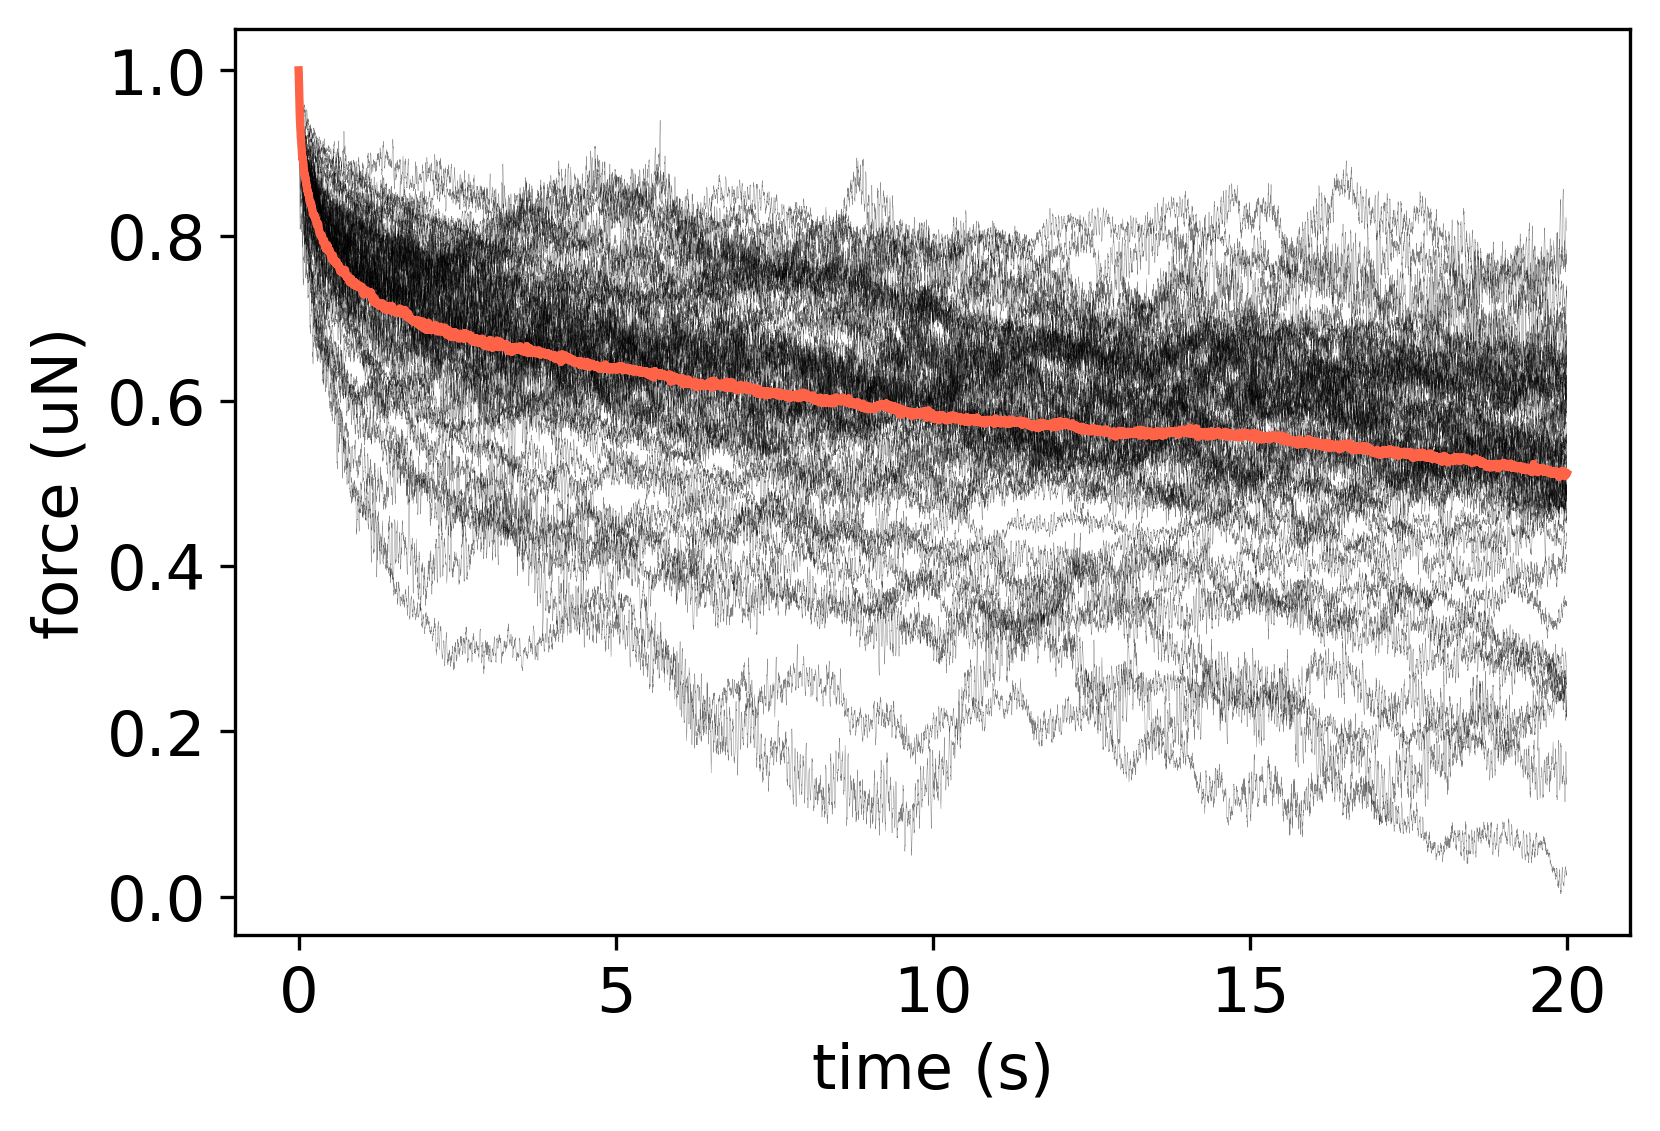

In [38]:
#Analysis
f_min=plot1w.kwargs["fmin"] #The minium acceptable value for the max force 
f_max = plot1w.kwargs["fmax"]#The maximum acceptable value for the max force
TMAX=plot1w.kwargs["TMAX"] #s 

tall = []
fall = []
for _, file in enumerate(data):
    curve=read_file(file) 
    z=curve[:,4]
    f=curve[:,1]
    t=curve[:,0]
    i_max_time = np.argmin((t-TMAX)**2)
    #Screen bad curves based on maximum force 
    #and skip analysis for curves that do not fulfill requirement 
    if thresholdw.value is True:
        if max(f) > f_max or max(f)<f_min:
            continue
    if multimaxw.value is True: 
        max_force = max(f)
        i_max_force=np.argmin((f-max_force)**2)
        t_max=t[i_max_force]
        if t_max>TIME_MULTIMAX:
            continue
    #Find maximum force and corresponding time index;
    #and plot from only max force. Align curves in time starting from max force value.
    max_force = max(f)
    i_max_force=np.argmin((f-max_force)**2)
    f=f[i_max_force::]
    t=t[i_max_force::]-t[i_max_force]
    #Offset curves 
    off = f[0]
    if off <0: 
        f = f-off
    else:
        f = f
    #Final variables to append
    normf=f[:i_max_time]/max(f[:i_max_time])
    t=t[:i_max_time]
    tall.append(t)
    fall.append(normf)
    plt.plot(t,normf,alpha=0.5,lw=0.1,c='k')

plt.xlabel('time (s)')
plt.ylabel('force (uN)')

#Find and plot average curve
t_av,f_av,f_err=getMedCurve(tall,fall,error=True)
plt.errorbar(t_av,f_av,c='tomato',lw=2,alpha=1)
plt.show()

# Save relaxation time in your favourite software 

In [49]:
relaxation_timew=widgets.BoundedFloatText(
    value=0.5,
    min=0,
    max=1.0,
    step=0.1,
    disabled=False
)
boxw=widgets.HBox([widgets.Label(value="Enter stress value for which relaxation time is calculated:"), relaxation_timew])
display(boxw)

In [50]:
# #Extract time at which force reaches % of original value (specified above)
# F_TARGET=relaxation_timew.value*(max(f_av)) 
# i_fclose = np.argmin((f_av-F_TARGET)**2) #this is the  point at which the force is closest to the target value 
# #(effect of noise? Maybe it would be better to fit the average curve with an exponentail and get the time from there)
# t_target=t_av[i_fclose]
# print(f"The time for which the stress relaxes to {(relaxation_timew.value*100.0)}% of the original value is {t_target}")

# Save average curve
The cell below saves the data from the average curve in an excel spreadsheet.
Please enter the sample name an an excel sheet will be created in the notebook directory containing the average force, the force error (sd), and the average time. These data can then be read and used to produce comparison plots below.

In [ ]:
# SAMPLE_NAME=""
# SAMPLE_NAME = SAMPLE_NAME + ".xlsx"
# data={"average force (uN)":f_av, "error force (uN)":f_err, "average time (s)": t_av}
# df=pd.DataFrame(data)
# df.to_excel(SAMPLE_NAME)

# Plot average curves for comparison (data saved above)

In [ ]:
# dir_average_curves="" #the directory where the average curves (excel files) are saved
# average_curves,data=get_files(dir_average_curves,ext=".xlsx")

...